# Face Keypoint Detection

## Imports

In [19]:
import tensorflow as tf
import numpy as np
import albumentations as A
import dlib
import cv2
import os
import matplotlib.pyplot as plt
import wandb
import airflow as air
from imutils import face_utils
from sklearn.utils import shuffle


## Data preparation


In [23]:
data_dir = 'D:/GigaFolder/projects/face-keypoint-detection/data/raw/'
image_size = 192
output_size = 68

In [4]:
face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

In [223]:
# okay so this need to be a few functions

# 1) Augmentation:
#   There's no need to redefine it for every func run
transform = A.Compose(
    [A.Rotate(p=0.6, limit=15),
     #  A.RandomCrop(height=750, width=750, p=0.2),
     A.HorizontalFlip(p=0.5),
     A.ImageCompression(quality_lower=20, quality_upper=70, p=1),
     A.GaussianBlur(blur_limit=(3, 13), sigma_limit=0, p=0.8),
     A.RandomBrightnessContrast(p=0.4)
     ],
    keypoint_params=A.KeypointParams(
        format='xy', remove_invisible=False)
)

def augment(image, keypoint):
    transformed = transform(image=image, keypoints=keypoint)
    image = transformed['image']
    image = np.array(image, dtype=np.uint8)
    keypoint = transformed['keypoints']
    return image, keypoint

# 2) Image&Keypoint reshaping to model-expected size
def reshape(image, keypoint):
    keypoint = np.array(keypoint, dtype=np.int16) / 1024 * image_size
    keypoint = keypoint.astype(dtype=np.uint8)

    image = cv2.resize(image, (image_size, image_size),
                       interpolation=cv2.INTER_AREA)

def create_dataset(dataset_path: str, image_size: int, maxi=np.Infinity):
    images = np.empty([0, image_size, image_size, 3], dtype=np.uint8)
    keypoints = np.empty([0, 68, 2], dtype=np.int16)
    
    p = "../shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(p)
    directory = os.fsencode(dataset_path)

    co = 0

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        image = cv2.imread(dataset_path + filename)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)
        for (_, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            keypoint = face_utils.shape_to_np(shape)

            image, keypoint = augment(image, keypoint)
            image, keypoint = reshape(image, keypoint)
            
            image = np.expand_dims(image, axis=0) 
            shape = np.expand_dims(shape, axis=0)

            images = np.append(images, image, axis=0)
            keypoints = np.append(keypoints, shape, axis=0)

            break
        co += 1
        if co > maxi:
            break
    return images, keypoints


def compress_splits(X, Y, dir):
    np.savez_compressed(dir + 'Xvalues.npz', X)
    np.savez_compressed(dir + 'Yvalues.npz', Y)


def uncompress_splits(dir: str):
    X = np.load(dir + 'Xvalues.npz')['arr_0']
    Y = np.load(dir + 'Yvalues.npz')['arr_0']

    return X, Y


def split_dataset(X, Y, test_ratio: float = 0.20):
    size = int(len(X) * test_ratio)
    return X[size:], X[:size], Y[size:], Y[:size]


In [221]:
i, k = create_dataset(dataset_path=data_dir, image_size=image_size)

In [224]:
compress_splits(i,k, '../data/')

In [227]:
i, k = shuffle(i, k, random_state=0)


In [234]:
train_x, test_x, train_y, test_y = split_dataset(i, k)


In [235]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))


In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


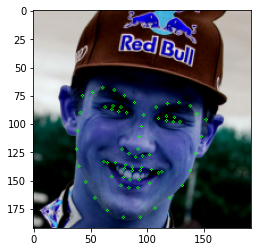

In [228]:
idx = 100
image = i[idx]
for x,y in k[idx]:
    image = cv2.circle(image, (int(x),
                       int(y)), 1, (0, 255, 0), 1)
plt.imshow(image)

## Model

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import Reshape


def build(image_size: int, outputs: tuple = (68, 2)):
    """Builds a model"""
    input_shape = (image_size, image_size, 3)

    model = Sequential(name = 'Keypoints detector v3.0.0')
    model.add(Conv2D(64, (1, 1), padding='same',
              input_shape=input_shape))
    model.add(Conv2D(96, (2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))


    model.add(Conv2D(128, (2, 2)))
    model.add(Conv2D(160, (2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),
              strides=(2, 2), padding='valid'))

    model.add(Conv2D(192, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(GlobalAveragePooling2D())

    model.add(Dense(500, activation='relu'))
    model.add(Dense(outputs[0] * outputs[1]))
    model.add(Reshape(outputs))
    return model


def compile_model(image_size: int):
    """Compiles the model with a given {input_size}"""
    model = build(image_size)

    model.compile(
        loss=tf.keras.losses.mean_squared_error,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mse', 'accuracy'])

    return model


In [ ]:
model = compile_model(image_size = image_size)
model.summary()

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=50,
                    validation_data=(x_test, y_test),
                    shuffle=True
                    )
